In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from models import TransformerLayer, AdaptiveISAB
import matplotlib.pyplot as plt
from typing import Optional

### Dataset

In [ ]:
def whiten_points(points):
    cov = np.cov(points, rowvar=False, bias=True)
    vals, vecs = np.linalg.eig(cov)
    whitened = (points - np.mean(points, axis=0)) @ vecs @ np.linalg.inv(np.sqrt(np.diag(vals)))
    return whitened

def generate_random_gaussian_path(sigma_min, sigma_max, num_sigmas_min, num_sigmas_max, peak_height_min, peak_height_max, num_points):
    points = np.zeros((num_points,2))
    sigma = np.random.uniform(sigma_min, sigma_max)
    peak_height = np.random.uniform(peak_height_min, peak_height_max)
    num_sigmas_left = np.random.randint(num_sigmas_min, num_sigmas_max+1)
    num_sigmas_right = np.random.randint(num_sigmas_min, num_sigmas_max+1)
    points[:,0] = np.linspace(-num_sigmas_left * sigma, num_sigmas_right * sigma, num_points)
    points[:,1] = peak_height * np.exp(-0.5 * (points[:,0] / sigma) ** 2)
    return whiten_points(points)
def generate_random_sin_path(omega_min, omega_max, num_periods_min, num_periods_max, num_points):
    points = np.zeros((num_points,2))
    omega = np.random.uniform(omega_min, omega_max)
    num_periods = np.random.randint(num_periods_min, num_periods_max+1)
    points[:,0] = np.linspace(0, num_periods * 2 * np.pi / omega, num_points)
    points[:,1] = np.sin(omega * points[:,0])
    return whiten_points(points)
def generate_random_fourier_path(num_frequencies_min, num_frequencies_max, amplitude_scale_min, amplitude_scale_max, frequency_scale_min, frequency_scale_max, num_points):
    points = np.zeros((num_points,2))
    points[:,0] = np.linspace(0, 2 * np.pi, num_points)
    num_frequencies = np.random.randint(num_frequencies_min, num_frequencies_max+1)
    amplitude_scale = np.random.uniform(amplitude_scale_min, amplitude_scale_max)
    frequency_scale = np.random.uniform(frequency_scale_min, frequency_scale_max)
    amplitudes = np.random.randn(num_frequencies) * amplitude_scale
    frequencies = np.random.randn(num_frequencies) * frequency_scale
    phases = np.random.uniform(0, 2 * np.pi, num_frequencies)
    points[:,1] = np.sum(amplitudes * np.sin(frequencies * points[:,0][:, None] + phases), axis=1)
    return whiten_points(points)
def generate_random_polynomial_path(min_degree, max_degree, coeff_scale_min, coeff_scale_max, eps_min, eps_max, num_points):
    points = np.zeros((num_points,2))
    eps = np.random.uniform(eps_min, eps_max)
    points[:,0] = np.arange(0, num_points)*eps - (num_points//2)*eps
    degree = np.random.randint(min_degree, max_degree + 1)
    coeff_scale = np.random.uniform(coeff_scale_min, coeff_scale_max)
    coefficients = np.random.randn(degree + 1) * coeff_scale
    points[:,1] = np.sum(points[:,None,0] ** np.arange(0, degree+1)[None, :] @ coefficients[:, None], axis=1)
    return whiten_points(points)
def random_rotations(points, num_rotations):
    angles = np.random.uniform(0, 2 * np.pi, num_rotations)
    cos = np.cos(angles)
    sin = np.sin(angles)
    rotated_points = np.zeros((num_rotations, points.shape[0], points.shape[1]))
    rotated_points[:, :, 0] = points[:, 0][None,:] * cos[:, None] - points[:, 1][None, :] * sin[:, None]
    rotated_points[:, :, 1] = points[:, 0][None,:] * sin[:, None] + points[:, 1][None, :] * cos[:, None]
    return rotated_points

In [ ]:
def generate_dataset(num_base_curves_per_type, num_rotations_per_curve, num_points, config_dict):
    dataset = []
    for curve_type, params in config_dict.items():
        for _ in range(num_base_curves_per_type):
            if curve_type == 'gaussian':
                points = generate_random_gaussian_path(**params, num_points=num_points)
            elif curve_type == 'sine':
                points = generate_random_sin_path(**params, num_points=num_points)
            elif curve_type == 'random_fourier':
                points = generate_random_fourier_path(**params, num_points=num_points)
            elif curve_type == 'random_polynomial':
                points = generate_random_polynomial_path(**params, num_points=num_points)
            else:
                raise ValueError(f"Unknown curve type: {curve_type}")
            rotated_points = random_rotations(points, num_rotations=num_rotations_per_curve)
            dataset.append(rotated_points)
    return np.concatenate(dataset, axis=0)

In [ ]:
class CurveDataset(torch.utils.data.Dataset):
    def __init__(self, data, noise_std):
        self.data = data
        self.noise_std = noise_std
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        base_curve = self.data[idx]
        noise = np.random.randn(*base_curve.shape) * self.noise_std
        noisy_curve = base_curve + noise
        noisy_curve = whiten_points(noisy_curve)
        noisy_curve = torch.tensor(noisy_curve, dtype=torch.float32)
        # we need to do a symmetry breaking since t -> 1 - t is also a valid ordering
        to_flip = noisy_curve[0,0] > noisy_curve[-1, 0]
        permutation = torch.randperm(noisy_curve.shape[0])
        noisy_curve = noisy_curve[permutation]
        t = permutation / noisy_curve.shape[0]  # normalize permutation
        if to_flip:
            t = 1.0 - t
        return noisy_curve, t

In [9]:
class CurveOrderingModel(nn.Module):
    def __init__(
        self,
       config_dict
    ):
        super().__init__()
        input_dim = config_dict.get('input_dim', 2)
        model_dim = config_dict.get('model_dim', 128)
        num_layers = config_dict.get('num_layers', 4)
        base_num_slots = config_dict.get('base_num_slots', 16)
        increase_num_slots = config_dict.get('increase_num_slots', False)
        num_heads = config_dict.get('num_heads', 4)
        mlp_ratio = config_dict.get('mlp_ratio', 2.0)
        alpha_init = config_dict.get('alpha_init', 0.1)
        drop_path_prob = config_dict.get('drop_path_prob', 0.0)
        attn_dropout = config_dict.get('attn_dropout', 0.0)
        self.input_net = nn.Sequential(
            nn.Linear(input_dim, model_dim // 2),
            nn.GELU(),
            nn.Linear(model_dim // 2, model_dim),
        )

        # ISAB stack with possibly increasing slot count
        self.isab_layers = nn.ModuleList([
            AdaptiveISAB(
                dim=model_dim,
                num_slots=base_num_slots * (2 ** i) if increase_num_slots else base_num_slots,
                num_heads=num_heads,
                alpha_init=alpha_init,
                drop_path_prob=drop_path_prob,
                attn_dropout=attn_dropout,
            )
            for i in range(num_layers)
        ])

        # Optional pointwise MLP (outside ISAB) for extra capacity
        hidden = int(model_dim * mlp_ratio)
        self.point_mlp = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, hidden),
            nn.GELU(),
            nn.Linear(hidden, model_dim),
        )

        self.head = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, N, input_dim)
        x = self.input_net(x)  # (B, N, model_dim)

        for layer in self.isab_layers:
            x = layer(x)

        # pointwise refinement
        x = x + self.point_mlp(x)

        t = torch.sigmoid(self.head(x)).squeeze(-1)  # (B, N)
        return t


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_config = {
    'input_dim': 2,
    'model_dim': 64,
    'base_num_slots': 16,
    'increase_num_slots': False,
    'num_layers': 3,
    'num_heads': 4,
    'mlp_ratio': 4,
    'attn_dropout': 0.1,
}
model = CurveOrderingModel(config_dict=model_config)
model = model.to(device)

In [11]:
num_epochs = 100
min_num_points = 50
max_num_points = 100
config_dict = {
    'gaussian': {'sigma_min': 0.5, 'sigma_max': 2.0, 'num_sigmas_min': 2, 'num_sigmas_max': 5, 'peak_height_min': 0.5, 'peak_height_max': 2.0},
    'sine': {'omega_min': 0.5, 'omega_max': 2.0, 'num_periods_min': 1, 'num_periods_max': 5},
    'random_fourier': {'num_frequencies_min': 3, 'num_frequencies_max': 6, 'amplitude_scale_min': 0.5, 'amplitude_scale_max': 2.0, 'frequency_scale_min': 0.5, 'frequency_scale_max': 2.0},
    'random_polynomial': {'min_degree': 2, 'max_degree': 5, 'coeff_scale_min': 0.5, 'coeff_scale_max': 2.0, 'eps_min': 0.1, 'eps_max': 0.5}
}
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
for epoch in range(num_epochs):
    data = generate_dataset(num_base_curves_per_type=1000, 
                            num_rotations_per_curve=50, 
                            num_points=np.random.randint(min_num_points, max_num_points+1), 
                            config_dict=config_dict)
    dataset = CurveDataset(data, noise_std=0.05)
    train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
    model.train()
    total_loss = 0.0
    for batch_idx, (x, t) in enumerate(train_loader):        
        optimizer.zero_grad()
        x = x.to(device)
        t = t.to(device)
        t_pred = model(x)
        loss = torch.nn.functional.smooth_l1_loss(t_pred, t, beta=0.02)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.6f}")
        
        total_loss += loss.item() * x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.6f}")
    torch.save({'config' : model_config, 'state_dict': model.state_dict()}, f'checkpoints/curve_ordering_model_epoch_{epoch}.pth')

Epoch 1, Batch 0, Loss: 0.277493
Epoch 1, Batch 1000, Loss: 0.157874
Epoch 1 completed. Average Loss: 0.157894
Epoch 2, Batch 0, Loss: 0.100671
Epoch 2, Batch 1000, Loss: 0.079589
Epoch 2 completed. Average Loss: 0.093610
Epoch 3, Batch 0, Loss: 0.101324
Epoch 3, Batch 1000, Loss: 0.054876
Epoch 3 completed. Average Loss: 0.066338
Epoch 4, Batch 0, Loss: 0.060964
Epoch 4, Batch 1000, Loss: 0.065780
Epoch 4 completed. Average Loss: 0.053317
Epoch 5, Batch 0, Loss: 0.049539
Epoch 5, Batch 1000, Loss: 0.047086
Epoch 5 completed. Average Loss: 0.049453
Epoch 6, Batch 0, Loss: 0.064340
Epoch 6, Batch 1000, Loss: 0.043869
Epoch 6 completed. Average Loss: 0.047819
Epoch 7, Batch 0, Loss: 0.047167
Epoch 7, Batch 1000, Loss: 0.039419
Epoch 7 completed. Average Loss: 0.042664
Epoch 8, Batch 0, Loss: 0.036717
Epoch 8, Batch 1000, Loss: 0.036802
Epoch 8 completed. Average Loss: 0.039265
Epoch 9, Batch 0, Loss: 0.031428
Epoch 9, Batch 1000, Loss: 0.028931
Epoch 9 completed. Average Loss: 0.033357
E

In [98]:
import numpy as np

rng = np.random.default_rng(0)

N = 50
t = np.linspace(0.0, 1.0, N)

x = t
y = t**2

points = np.stack([x, y], axis=1)      # (N, 2)

# rumore leggero
points += 0.01 * rng.standard_normal(size=points.shape)

points = random_rotations(points, 1)[0]
# shuffle mantenendo l'allineamento
perm = rng.permutation(N)
points = points[perm]
t_true = t[perm]

In [99]:
with torch.no_grad():
    model.eval()
    predicted_time = model(torch.Tensor(whiten_points(points)).to(device).unsqueeze(0)).squeeze(0).cpu().numpy()
    model.train()

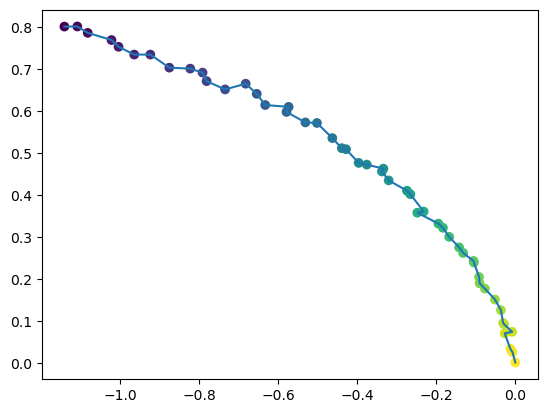

In [100]:
plt.scatter(points[:,0], points[:,1], c = predicted_time, label='Noisy Points') 
plt.plot(points[np.argsort(predicted_time),0], points[np.argsort(predicted_time),1],  label='Predicted Time') 
#plt.plot(points[np.argsort(t_true),0], points[np.argsort(t_true),1],  label='True Time') 